<a href="https://colab.research.google.com/github/wahyukesuma1/Data-Mining-Final-Project/blob/main/Data_Mining_%7C_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import dates
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

# Supervised Learning

Analisis Tren Penjualan Walmart

## Business Understanding

Goals Perusahaan:

Meningkatkan penjualan dan pendapatan perusahaan dengan 
mengidentifikasi tren penjualan yang signifikan dan memprediksi permintaan pelanggan di masa depan.

Memahami perilaku konsumen dan preferensi mereka untuk memperbaiki layanan dan pengalaman pelanggan.

Menemukan peluang bisnis baru dan mengembangkan strategi pemasaran yang efektif.

Tujuan Penggunaan Data Mining:
Mengidentifikasi tren penjualan dan prediksi permintaan masa depan.

Menganalisis perilaku konsumen dan preferensi mereka.

Memprediksi penjualan di toko-toko yang berbeda dan memperbaiki stok produk.

Project Plan:
Mengumpulkan data penjualan dari toko-toko Walmart yang berbeda.

Membersihkan dan mengevaluasi data untuk mengidentifikasi tren penjualan dan pola pembelian pelanggan.

Menerapkan teknik data mining seperti regresi dan klasifikasi untuk memprediksi permintaan masa depan.

Menggunakan algoritma klastering untuk mengelompokkan produk dan pelanggan dengan karakteristik yang sama.

Membangun model prediksi penjualan untuk masing-masing toko dan produk.

Menganalisis hasil untuk memperbaiki stok produk dan menentukan strategi pemasaran yang efektif.


## Data Understanding

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/hadiprasetiyo/dataset-data-mining/main/Walmart_Store_sales.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


#Preparation

###Cleaning

In [ ]:
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [ ]:
df[df.duplicated()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment


In [ ]:
# List untuk menyimpan hasil
results = []

cols = df.select_dtypes(include=['float64', 'int64'])

for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    percent_outliers = (len(outliers)/len(df))*100
    results.append({'Kolom': col, 'Persentase Outliers': percent_outliers})

# Dataframe dari list hasil
results_df = pd.DataFrame(results)
results_df.set_index('Kolom', inplace=True)
results_df = results_df.rename_axis(None, axis=0).rename_axis('Kolom', axis=1)

# Tampilkan dataframe
display(results_df)

Kolom,Persentase Outliers
Store,0.000000
Weekly_Sales,0.528361
Holiday_Flag,6.993007
Temperature,0.046620
Fuel_Price,0.000000
CPI,0.000000
Unemployment,7.474747


Akan dihapus data outliers pada seluruh kolom yang memiliki persentase di bawah 10% karena jumlah data yang tergolong banyak yaitu 6000+ baris, tetapi pada kolom Holiday_Flag tidak dihapus, sebab kolom tersebut berisikan angka biner saja

In [ ]:
cols = ['Weekly_Sales','Temperature','Unemployment']

# List untuk menyimpan hasil
results = []

for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    percent_outliers = (len(outliers)/len(df))*100
    if percent_outliers < 10:
      df = df[~((df[col] > upper_bound) | (df[col] < lower_bound))]
    outliers_after = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    percent_outliers_after = (len(outliers_after)/len(df))*100
    results.append({'Kolom': col, 'Persentase Outliers': percent_outliers_after})

# Dataframe dari list hasil
results_df = pd.DataFrame(results)
results_df.set_index('Kolom', inplace=True)
results_df = results_df.rename_axis(None, axis=0).rename_axis('Kolom', axis=1)

# Tampilkan dataframe
display(results_df)

Kolom,Persentase Outliers
Weekly_Sales,0.0
Temperature,0.0
Unemployment,0.0


In [ ]:
df_clean = df

###Transform & Extraction

In [ ]:
warnings.filterwarnings("ignore")

df_clean['Date'] =  pd.to_datetime(df_clean['Date'])
df_clean['Day']= pd.DatetimeIndex(df_clean['Date']).day
df_clean['Month'] = pd.DatetimeIndex(df_clean['Date']).month
df_clean['Year'] = pd.DatetimeIndex(df_clean['Date']).year

# Calculate the average production
avg_production = df_clean['Weekly_Sales'].mean()

# Create a new column 'Produksi_Kategori' with binary categories based on average production
df_clean['Sales_Categories'] = df_clean['Weekly_Sales'].apply(lambda x: 1 if x > avg_production else 0)

In [ ]:
df_trans_ext = df_clean
df_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,Sales_Categories
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106,2,5,2010,1
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106,2,12,2010,1
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010,1
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010,1
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106,3,5,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,28,9,2012,0
6431,45,2012-05-10,733455.07,0,64.89,3.985,192.170412,8.667,10,5,2012,0
6432,45,2012-12-10,734464.36,0,54.47,4.000,192.327265,8.667,10,12,2012,0
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,19,10,2012,0


<class 'numpy.float64'>


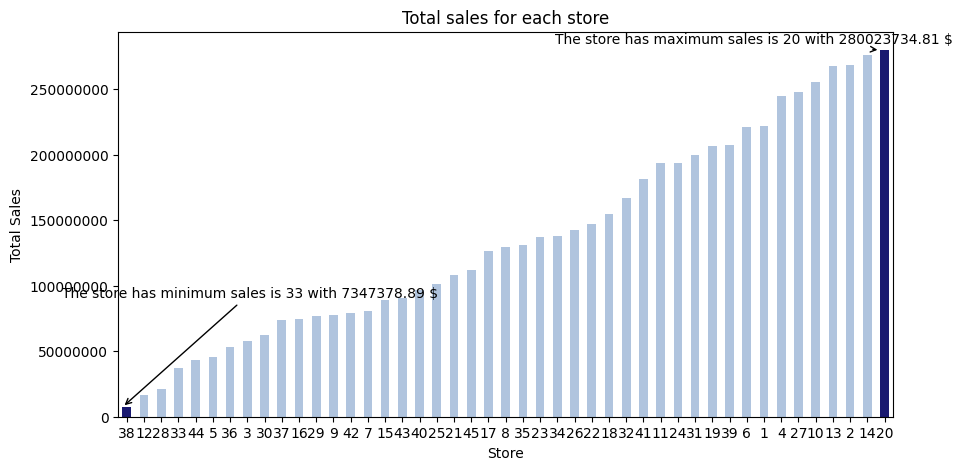

In [ ]:
plt.figure(figsize=(10,5))

# Sum Weekly_Sales for each store, then sortded by total sales
total_sales_for_each_store = df_clean.groupby('Store')['Weekly_Sales'].sum().sort_values() 
total_sales_for_each_store_array = np.array(total_sales_for_each_store) # convert to array

# Assigning a specific color for the stores have the lowest and highest sales
clrs = ['lightsteelblue' if ((x < max(total_sales_for_each_store_array)) and (x > min(total_sales_for_each_store_array))) else 'midnightblue' for x in total_sales_for_each_store_array]


ax = total_sales_for_each_store.plot(kind='bar',color=clrs);

# store have minimum sales
p = ax.patches[0]
print(type(p.get_height()))
ax.annotate("The store has minimum sales is 33 with {0:.2f} $".format((p.get_height())), xy=(p.get_x(), p.get_height()), xycoords='data',
            xytext=(0.17, 0.32), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='center')


# store have maximum sales 
p = ax.patches[44]
ax.annotate("The store has maximum sales is 20 with {0:.2f} $".format((p.get_height())), xy=(p.get_x(), p.get_height()), xycoords='data',
            xytext=(0.82, 0.98), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            horizontalalignment='center', verticalalignment='center')


# plot properties
plt.xticks(rotation=0)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Total sales for each store')
plt.xlabel('Store')
plt.ylabel('Total Sales');

In [ ]:
data_std = pd.DataFrame(df_clean.groupby('Store')['Weekly_Sales'].std().sort_values(ascending=False))
print("The store has maximum standard deviation is "+str(data_std.head(1).index[0])+" with {0:.0f} $".format(data_std.head(1).Weekly_Sales[data_std.head(1).index[0]]))

The store has maximum standard deviation is 23 with 250838 $


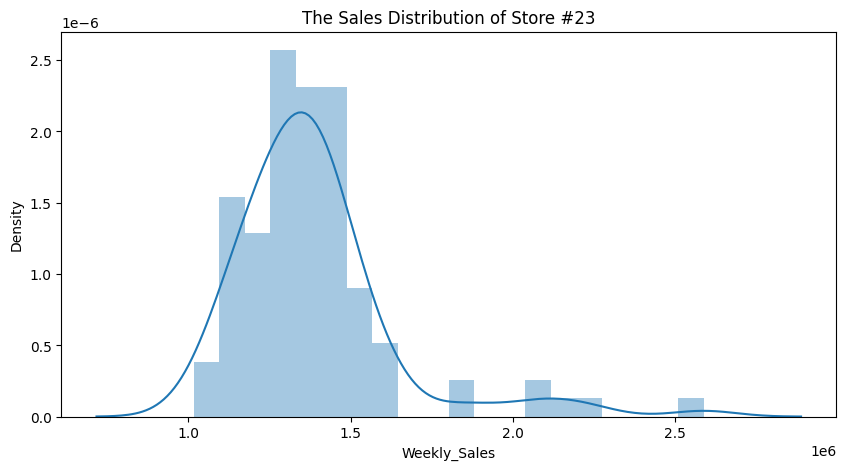

In [ ]:
# Distribution of store has maximum standard deviation
plt.figure(figsize=(10,5))
sns.distplot(df_clean[df_clean['Store'] == data_std.head(1).index[0]]['Weekly_Sales'])
plt.title('The Sales Distribution of Store #'+ str(data_std.head(1).index[0]));

In [ ]:
coef_mean_std = pd.DataFrame(df_clean.groupby('Store')['Weekly_Sales'].std() / df_clean.groupby('Store')['Weekly_Sales'].mean())
coef_mean_std = coef_mean_std.rename(columns={'Weekly_Sales':'Coefficient of mean to standard deviation'})
coef_mean_std

,Coefficient of mean to standard deviation
Store,
1,0.100292
2,0.088679
3,0.115021
4,0.075860
5,0.118668
6,0.121608
7,0.197964
8,0.116953
9,0.126895


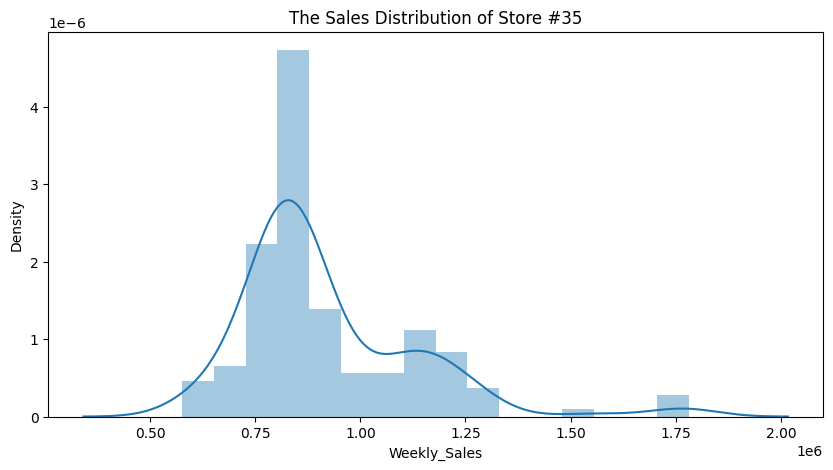

In [ ]:
# Distribution of store has maximum coefficient of mean to standard deviation
coef_mean_std_max = coef_mean_std.sort_values(by='Coefficient of mean to standard deviation')
plt.figure(figsize=(10,5))
sns.distplot(df_clean[df_clean['Store'] == coef_mean_std_max.tail(1).index[0]]['Weekly_Sales'])
plt.title('The Sales Distribution of Store #'+str(coef_mean_std_max.tail(1).index[0]));

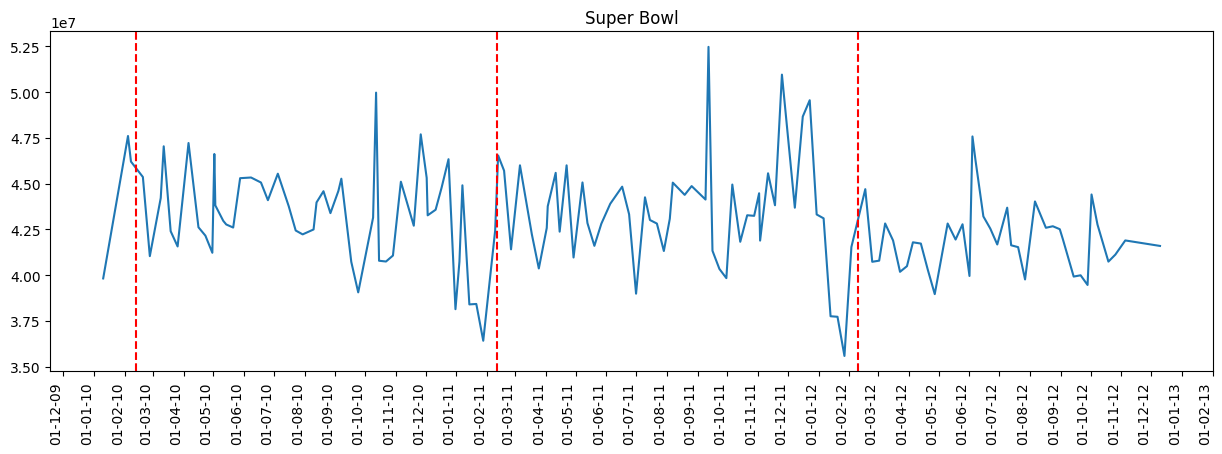

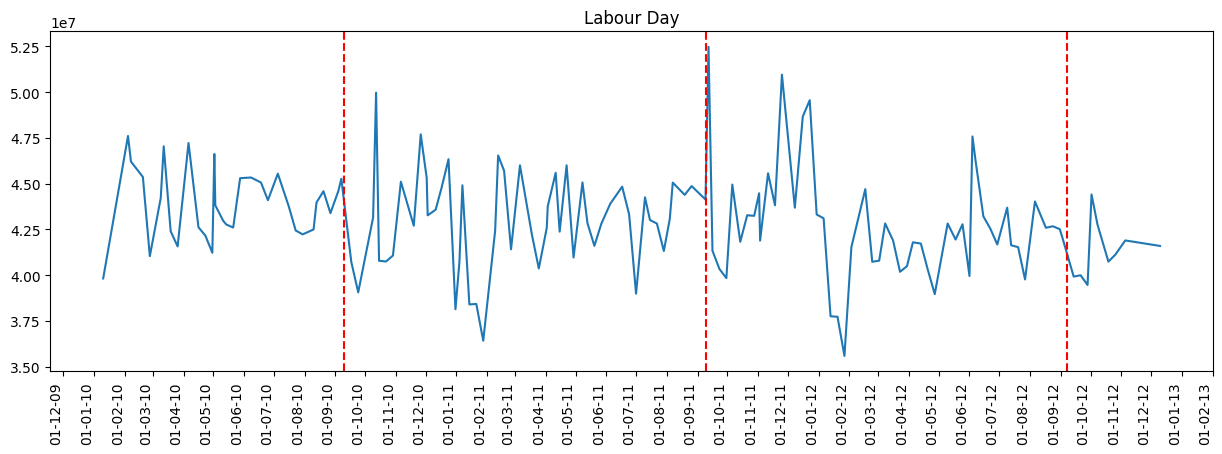

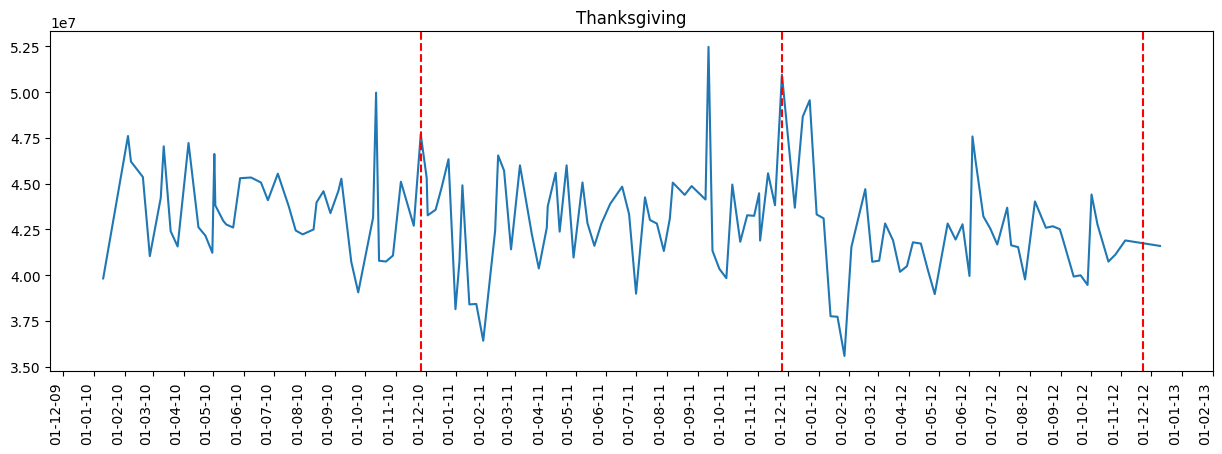

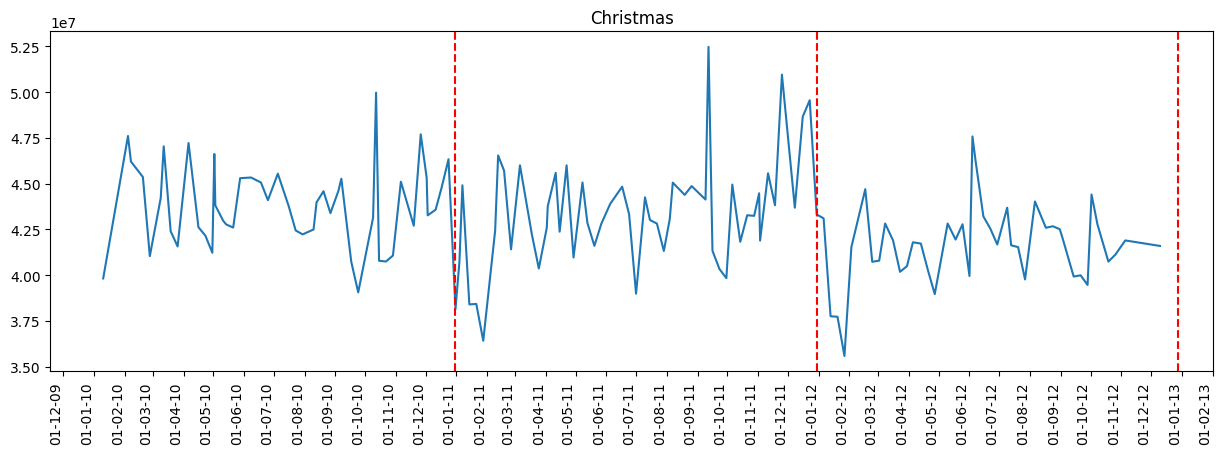

In [ ]:
def plot_line(df,holiday_dates,holiday_label):
    fig, ax = plt.subplots(figsize = (15,5))  
    ax.plot(df['Date'],df['Weekly_Sales'],label=holiday_label)
    
    for day in holiday_dates:
        day = datetime.strptime(day, '%d-%m-%Y')
        plt.axvline(x=day, linestyle='--', c='r')
    

    plt.title(holiday_label)
    x_dates = df['Date'].dt.strftime('%Y-%m-%d').sort_values().unique()
    xfmt = dates.DateFormatter('%d-%m-%y')
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(dates.DayLocator(1))
    plt.gcf().autofmt_xdate(rotation=90)
    plt.show()


total_sales = df_clean.groupby('Date')['Weekly_Sales'].sum().reset_index()
Super_Bowl =['12-2-2010', '11-2-2011', '10-2-2012']
Labour_Day =  ['10-9-2010', '9-9-2011', '7-9-2012']
Thanksgiving =  ['26-11-2010', '25-11-2011', '23-11-2012']
Christmas = ['31-12-2010', '30-12-2011', '28-12-2012']
    
plot_line(total_sales,Super_Bowl,'Super Bowl')
plot_line(total_sales,Labour_Day,'Labour Day')
plot_line(total_sales,Thanksgiving,'Thanksgiving')
plot_line(total_sales,Christmas,'Christmas')

###Reduction

In [ ]:
df_trans_ext = df_trans_ext.drop(['Weekly_Sales','Date'],axis=1)

###Slicing

In [ ]:
df_sliced = df_trans_ext.sample(n=1000, random_state=42)

###Formatting

#####Encoding

In [ ]:
df_encode = pd.get_dummies(df_sliced)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in df_encode:
  if df_encode[col].dtypes != int:
    df_encode[col] = le.fit_transform(df_encode[col])

######Splitting

In [ ]:
x = df_encode.drop(columns=['Sales_Categories'])
y = df_encode['Sales_Categories']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#####Cross Validation

In [ ]:
# definisikan model KNN
clf = KNeighborsClassifier()

# definisikan hyperparameter yang ingin diuji
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# inisialisasi GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5)

# latih model dengan GridSearchCV
grid_search.fit(x_train, y_train)

# tampilkan parameter terbaik
print("Nilai k terbaik:", grid_search.best_params_['n_neighbors'])

# tampilkan skor validasi terbaik
print("Skor validasinya:", grid_search.best_score_)

Nilai k terbaik: 3
Skor validasinya: 0.5614285714285714


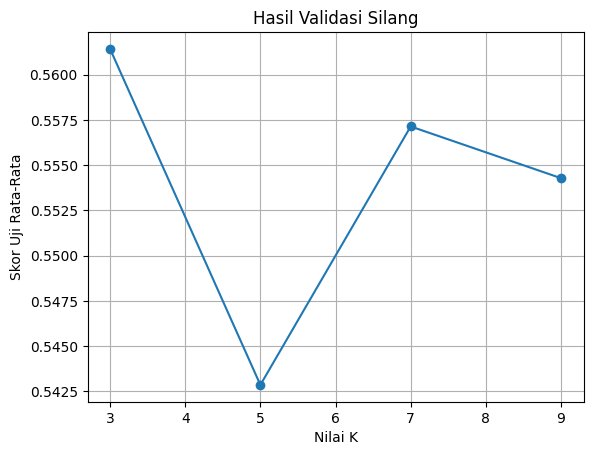

In [ ]:
# ambil nilai skor validasi dari grid search
mean_scores = grid_search.cv_results_['mean_test_score']
std_scores = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

# plot hasil dari grid search
plt.errorbar(
    [params[i]['n_neighbors'] for i in range(len(params))],
    mean_scores,
    fmt='o-'
)
plt.xlabel('Nilai K')
plt.ylabel('Skor Uji Rata-Rata')
plt.title('Hasil Validasi Silang')
plt.grid(True)
plt.show()

#Modelling

###PreProcessing

In [ ]:
scaler = StandardScaler()

# fit and transform the training data
x_train_scaled = scaler.fit_transform(x_train)

# convert the scaled training data to a Pandas DataFrame
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=x_train.columns)

# transform the testing data using the fitted scaler
x_test_scaled = scaler.transform(x_test)

# convert the scaled testing data to a Pandas DataFrame
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=x_test.columns)

###Modelling

#####GNB

In [ ]:
class GaussianNB:
    # Constructor
    def __init__(self):
        self.sigmas = dict()
        self.dispersions = dict()
        self.probs = dict()
        self.index = None
        self.targets = None
        self.columns = None
    
    def fit(self, x, y):
        # Convert x to DataFrame
        x = pd.DataFrame(x, columns=self.columns)

        # Store the original index of x
        self.index = x.index

        # Preparing sigma / dispersion dictionaries for numeric columns
        self.sigmas = {}
        self.dispersions = {}
        for column in x.select_dtypes(include=[np.number]):
            self.sigmas[column] = {}
            self.dispersions[column] = {}
            for target in y.unique():
                sample = np.array(x[y.values == target][column])
                self.sigmas[column][target] = sample.std()
                self.dispersions[column][target] = sample.mean()
                self.probs[column] = len(sample) / len(x)

        self.targets = y.unique()
        self.columns = x.columns

    # Predict method
    def predict(self, X):
        predicts = list()
        for row in X.to_numpy():
            target_prob_dict = dict()
            for target in self.targets:
                for x, column in zip(row, self.columns):
                    x = float(x)
                    sigma = self.sigmas[column][target]
                    dispersion = self.dispersions[column][target]
                    prob = self.probs[column]
                    target_prob = ((1 / np.sqrt(np.pi*sigma)) * np.exp(-( (x-dispersion)**2 / (2*sigma**2)))) * prob

                    if target not in target_prob_dict:
                        target_prob_dict[target] = target_prob
                    else:
                        target_prob_dict[target] *= target_prob
                        
            # Get the predicted class based on the highest probability
            predicted_class = max(target_prob_dict, key=target_prob_dict.get)
            predicts.append(predicted_class)
        
        return predicts
    
    def print(self):
        print("Sigmas:")
        for column in self.sigmas:
            print(f"\t{self.columns[column]}")

In [ ]:
# create a Gaussian Naive Bayes object
gnb = GaussianNB()

# train the model on the scaled training data
gnb.fit(x_train_scaled_df, y_train)

# make predictions on the scaled testing data
gnb_pred = gnb.predict(x_test_scaled_df)


#####KNN

In [ ]:
class KNeighbors:
    def __init__(self, n_neighbors=None):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        self.X_train = np.array(X)
        self.y_train = np.array(y)
        
    def predict(self, X_test):
        X_test = np.array(X_test)
        y_pred = np.zeros(X_test.shape[0], dtype=self.y_train.dtype)
        for i, x_test in enumerate(X_test):
            distances = np.sqrt(np.sum((self.X_train - x_test)**2, axis=1))
            indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_classes = self.y_train[indices]
            y_pred[i] = np.argmax(np.bincount(k_nearest_classes))
        return y_pred

In [ ]:
# Inisialisasi model KNN dengan k=5
knn = KNeighbors(n_neighbors=3)

# Train model menggunakan data train
knn.fit(x_train_scaled_df, y_train)

# Prediksi label pada data test
knn_pred = knn.predict(x_test_scaled_df)

#####C4.5

In [ ]:
# inisialisasi model Decision Tree Classifier
dtc = DecisionTreeClassifier()

# train model pada data train
dtc.fit(x_train_scaled_df, y_train)

# evaluasi model pada data test
dtc_pred = dtc.predict(x_test_scaled_df)

#Evaluation

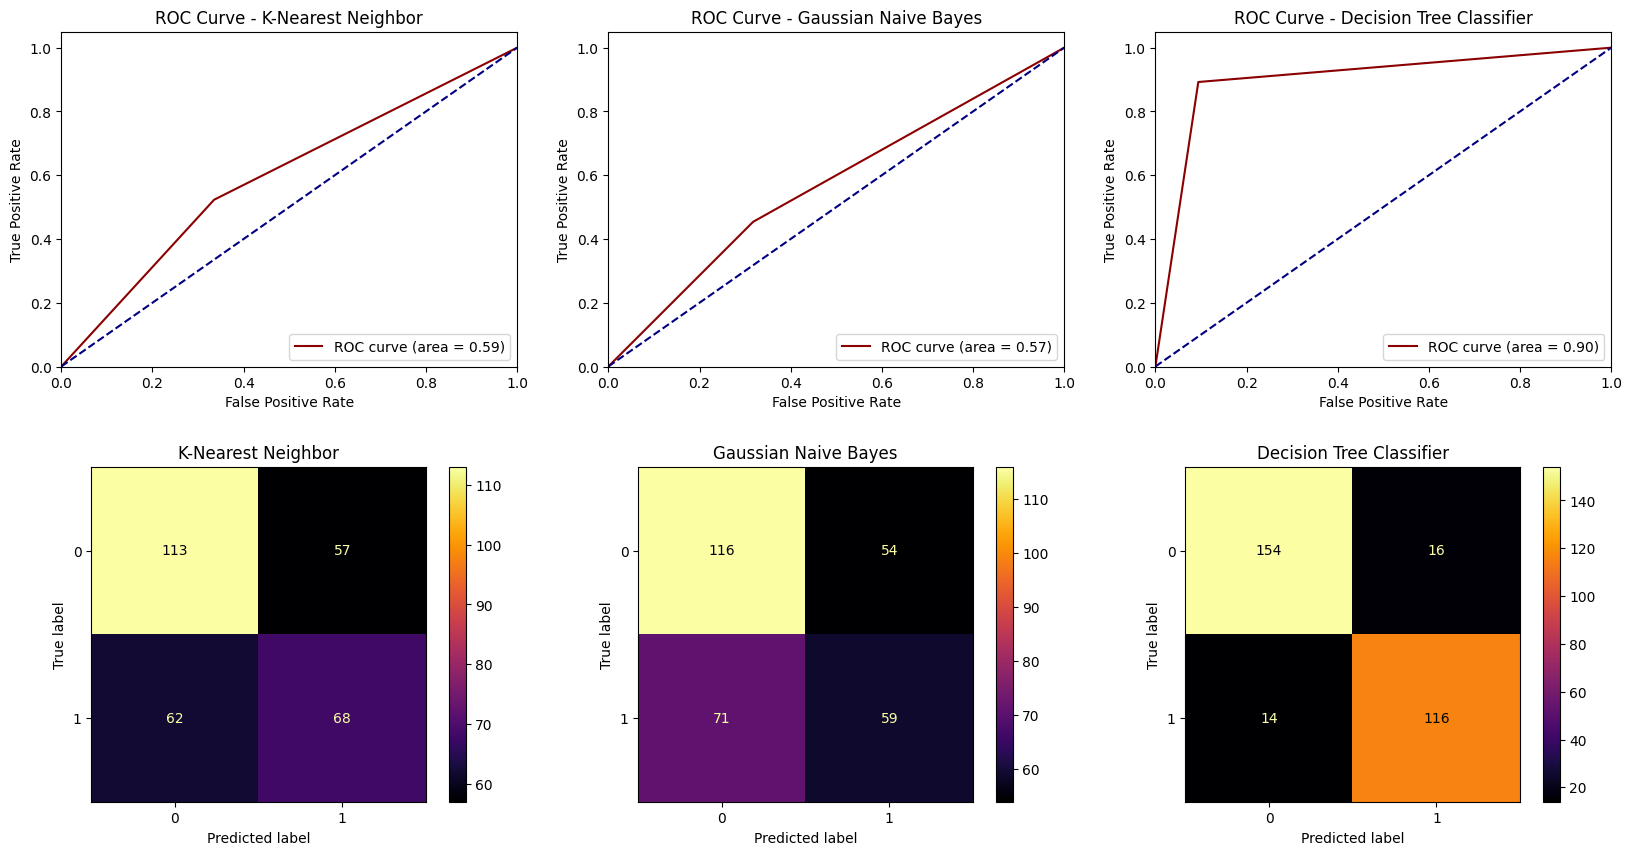

,Accuracy (%),Precision (%),Recall (%),ROC-AUC (%),F1-Score (%)
K-Nearest Neighbor,60.333333,54.400000,52.307692,59.389140,53.333333
Gaussian Naive Bayes,58.333333,52.212389,45.384615,56.809955,48.559671
Decision Tree Classifier,90.000000,87.878788,89.230769,89.909502,88.549618


In [ ]:
# buat list model dan nama model
models = [knn, gnb, dtc]
model_names = ['K-Nearest Neighbor', 'Gaussian Naive Bayes', 'Decision Tree Classifier']

# inisialisasi list untuk menyimpan hasil evaluasi
acc_scores = []
pre_scores = []
rec_scores = []
roc_scores = []
f1_scores = []

# buat figure dan axes untuk menampilkan visualisasi
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# loop untuk setiap model
for i, model in enumerate(models):
    # prediksi target variabel pada data uji
    y_pred = model.predict(x_test_scaled_df)

    # hitung confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # hitung nilai roc-auc
    roc = roc_auc_score(y_test, y_pred)

    # hitung false positive rate (fpr) dan true positive rate (tpr) untuk kurva roc
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # tampilkan kurva roc
    roc_display = axes[0,i].plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.2f)' % roc)
    roc_display = axes[0,i].plot([0, 1], [0, 1], color='navy', linestyle='--')
    roc_display = axes[0,i].set_xlim([0.0, 1.0])
    roc_display = axes[0,i].set_ylim([0.0, 1.05])
    roc_display = axes[0,i].set_xlabel('False Positive Rate')
    roc_display = axes[0,i].set_ylabel('True Positive Rate')
    roc_display = axes[0,i].set_title('ROC Curve - ' + model_names[i])
    roc_display = axes[0,i].legend(loc="lower right")

    # tambahkan baris kosong
    fig.subplots_adjust(hspace=0.3)

    # tampilkan confusion matrix
    cm_display = ConfusionMatrixDisplay(cm).plot(ax=axes[1,i], cmap='inferno')
    cm_display.ax_.set_title(model_names[i])

    # hitung true negative, false positive, false negative, true positive
    tn, fp, fn, tp = cm.ravel()

    # hitung akurasi, precision, recall, dan f1-score
    ac = (tp + tn) / (tp + fp + fn + tn)
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    f1 = (2 * pr * rc) / (pr+rc)

    # simpan hasil evaluasi pada list
    acc_scores.append(ac * 100)
    pre_scores.append(pr * 100)
    rec_scores.append(rc * 100)
    roc_scores.append(roc * 100)
    f1_scores.append(f1 * 100)

# tampilkan visualisasi
plt.show()

# buat dataframe dari hasil evaluasi
df_eval = pd.DataFrame({'': model_names,
                        'Accuracy (%)': acc_scores,
                        'Precision (%)': pre_scores,
                        'Recall (%)': rec_scores,
                        'ROC-AUC (%)': roc_scores,
                        'F1-Score (%)': f1_scores})
# set index dataframe menjadi kosong
df_eval = df_eval.set_index('')

# ubah nama axis pada index dan kolom
df_eval = df_eval.rename_axis(None, axis=0).rename_axis('', axis=1)

# menampilkan dataframe dengan style untuk highlight nilai tertinggi
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: green' if v else '' for v in is_max]

df_eval = df_eval.style.apply(highlight_max, axis=0)
# tampilkan dataframe
display(df_eval)

# Deployment

In [ ]:
df_sliced.to_csv('Supervised - Deployment.csv')